In [1]:
magma_dir = '/home/marco/epfl/magma/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'bart'
MODELS = {}

In [16]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/assign_bullets_para_wordembed/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

### **Init**

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [7]:
def import_model_tok(model_name_or_path):
    global MODELS

    if model_name_or_path in MODELS.keys():
        print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Nice Print

In [8]:
def print_example(idx, text, summ, summ_num_tok, bull):
    print(idx)
    print(fill(text, 100))
    print()
    print('Prediction (%d tokens):'%summ_num_tok)
    print(fill(summ, 100))
    print()
    print('Reference:')
    print(fill(bull, 100))
    print()
    print(''.join(['#']*100))
    print()

##### Print Examples

In [9]:
def print_examples(model_name_or_path, df, n_examples=10):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():

        summ_enc = model.generate(
            tokenizer.encode(row.text, return_tensors='pt').to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)[0]
        summ_num_tok = len(summ_enc)
        summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

        print_example(idx, row.text, summ, summ_num_tok, row.bullets)

##### Plot Evaluation

In [41]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **Sentence-Transformers**

In [18]:
data_dir_st = data_dir + 'st/'

In [19]:
df_train = pd.read_csv(data_dir_st + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir_st + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir_st + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [21]:
print_examples('sshleifer/distilbart-cnn-12-6', df_train)

[*] importing the model

BartConfig {
  "_name_or_path": "sshleifer/distilbart-cnn-12-6",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": true,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LA

(9781910797495, 'chp1')
Because it is an experience, pain itself cannot be measured directly. Pain, like consciousness itself, is constructed by complex brain processes that
are strongly affected by a person's attitudes, beliefs, personality and interpretation of the significance of nociceptive stimuli. Central to the
understanding of clinical pain is the concept that pain may be present without an obvious peripheral source or cause. Mechanisms of neuropathic pain.
Definition. Neuropathic pain is initiated or caused by a primary lesion of the PNS or CNS. Patients often complain not only of spontaneous pain, but
also of pain from stimuli that are not normally painful (allodynia). For example, a light touch may be described as painful.

Prediction (47 tokens):
 Neuropathic pain is initiated or caused by a primary lesion of the PNS or CNS. Patients often
complain not only of spontaneous pain, but also of pain from stimuli that are not normally painful
(allodynia)

Reference:
Neuropathic p

##### Print Val Examples

In [22]:
print_examples('sshleifer/distilbart-cnn-12-6', df_val)

[+] model already present in cache

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of low back pain syndromes. The most common causes of
low back pain are mechanical in origin. Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal structure.
The most important traumatic factors in low back pain relate to soft tissue structures. Precise identification of the injured tissue, and the role of
that injury in the consequent pain and dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet joints,
ligaments or spinal nerves. Aging causes modification of these structures over time, and different parts of the spine tend to be at greater risk for
change or injury during different decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the sixth decade of
life (Table 3.1).

Prediction (46 tokens):
 M

(9781910797815, 'chp9')
There are no specific diagnostic criteria for MPN-BP. The principal criterion is the same as for de novo acute myeloid leukemia (AML): more than 20%
blasts in bone marrow or peripheral blood. Persistence is also important if only peripheral blood blasts are considered. Importantly, acceleration or
progression of myelofibrosis is usually apparent before the development of overt leukemia. Signs of this include.

Prediction (47 tokens):
 There are no specific diagnostic criteria for MPN-BP. The principal criterion is the same as for de
novo acute myeloid leukemia (AML): more than 20% blasts in bone marrow or peripheral blood.

Reference:
Signs of accelerating myelofibrosis may precede the development of overt leukemia.

####################################################################################################

(9783318068207, 'hh-7')
NGS testing for predictive biomarkers. EGFR activation of the RAS/RAF/MEK/ERK pathway (see Chapter 1) plays an important ro

##### Print Test Examples

In [23]:
print_examples('sshleifer/distilbart-cnn-12-6', df_test)

[+] model already present in cache

(9781908541277, 'ch_8')
Indications. OXC has a similar spectrum of efficacy to CBZ against partial and tonic-clonic seizures. It tends to be better tolerated than CBZ with
fewer neurotoxic side effects. Dosage. The recommended starting dose for OXC in adults is 150-600 mg daily in two doses. The dose can be titrated
upwards as clinically indicated to 3000-4000 mg daily. A starting dose of 5 mg/kg daily in children over 3 years of age can be prescribed, increasing
gradually to a maintenance dose of about 30 mg/kg daily. Patients already on CBZ may be switched immediately to OXC using a dosage ratio of 1.5 OXC to
1 CBZ. Particular care in immediate switching needs to be taken when the daily CBZ dose exceeds 1200 mg. Plasma concentrations of the clinically
active metabolite of OXC increase linearly with dose. No studies, however, have attempted to relate elevated plasma levels to efficacy or toxicity.

Prediction (41 tokens):
 OXC has a similar spectrum

(9781910797211, 'ch04')
Dopamine agonist versus levodopa. In younger patients, the issues of neuroprotection and dyskinesias should be considered. The results of four
controlled dopamine-agonist monotherapy trials have been published and suggest that initiation of treatment with an agonist is beneficial in the early
stages of Parkinson's disease. However, the results of the PD Med study, a multicenter real-life pragmatic study, reporting on quality of life-related
outcomes in both young and old patients with Parkinson's disease, is likely to generate considerable controversy regarding the use of dopamine
agonists and the choice of initial therapy. In total, 1620 patients with early Parkinson's disease were recruited and given one of three initial
treatment regimens. levodopa formulation (528 patients). levodopa-sparing strategy - dopamine agonist (632 patients). levodopa-sparing strategy - MAOB
inhibitor (selegiline; 460 patients). The study started in 2000 with a median follow-up of 3

##### Summarize Test

In [24]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [25]:
df_test = summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

[+] model already present in cache

100%|██████████| 25/25 [24:04<00:00, 57.76s/it]


### **Evaluation**

In [26]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [48]:
def evaluate_model(df, model_name_or_path):
    df_eval = df.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary_'+model_name_or_path: lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df_eval

In [49]:
evaluate_model(df_test, 'sshleifer/distilbart-cnn-12-6')

,,text,bullets,summary_sshleifer/distilbart-cnn-12-6,rouge1_precision_sshleifer/distilbart-cnn-12-6,rouge1_recall_sshleifer/distilbart-cnn-12-6,rouge1_fmeasure_sshleifer/distilbart-cnn-12-6,rouge2_precision_sshleifer/distilbart-cnn-12-6,rouge2_recall_sshleifer/distilbart-cnn-12-6,rouge2_fmeasure_sshleifer/distilbart-cnn-12-6,rougeL_precision_sshleifer/distilbart-cnn-12-6,rougeL_recall_sshleifer/distilbart-cnn-12-6,rougeL_fmeasure_sshleifer/distilbart-cnn-12-6
book,chapter,,,,,,,,,,,,
9781910797631,chp6,Prevention and management. By far the most res...,The treatment rather than the prevention of de...,Preventive strategies may be directed toward ...,0.366337,0.430233,0.395722,0.064677,0.076023,0.069892,0.168317,0.197674,0.181818
9781910797426,ch03,Epidemiology and risk factors. Gallstones are ...,The prevalence of gallstones is greater in peo...,Gallstones are a significant cause of morbidi...,0.461929,0.710938,0.560000,0.239796,0.370079,0.291022,0.324873,0.500000,0.393846
9781908541277,ch_12,Nearly 1 in 3 patients reports significant con...,Depression and anxiety are common in patients ...,Depression is the most prevalent psychiatric ...,0.264407,0.523490,0.351351,0.078231,0.155405,0.104072,0.132203,0.261745,0.175676
9781910797907,chp6,When to transfuse. There is no set standard wi...,The decision for transfusion therapy relates t...,There is no set standard with regard to trans...,0.394118,0.511450,0.445183,0.153846,0.200000,0.173913,0.258824,0.335878,0.292359
9781908541277,ch_8,Modern antiepileptic drugs. After a hiatus of ...,Sixteen new antiepileptic drugs (AEDs) have be...,16 new AEDs and two devices - the vagus nerve...,0.171875,0.423077,0.244444,0.031496,0.078431,0.044944,0.125000,0.307692,0.177778
9781910797006,ch08,Acute exacerbations of chronic obstructive pul...,Acute exacerbations of COPD are common and pla...,"In the UK, respiratory admissions account for...",0.204461,0.617978,0.307263,0.070896,0.215909,0.106742,0.107807,0.325843,0.162011
9781910797105,ch06,Morphological findings. MRI studies confirmed ...,People with schizophrenia exhibit gray matter ...,People with schizophrenia exhibit decreased v...,0.234375,0.728155,0.354610,0.150470,0.470588,0.228029,0.203125,0.631068,0.307329
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,The adoption of broad NGS gene panels may sup...,0.239544,0.516393,0.327273,0.057252,0.123967,0.078329,0.140684,0.303279,0.192208
9781910797105,ch04,Studies in twins involve probands with schizop...,Identical twins show a 45% concordance rate. H...,MZ twins share 100% of their genes and DZ twi...,0.216216,0.563380,0.312500,0.032609,0.085714,0.047244,0.102703,0.267606,0.148438


##### Plot Evaluation

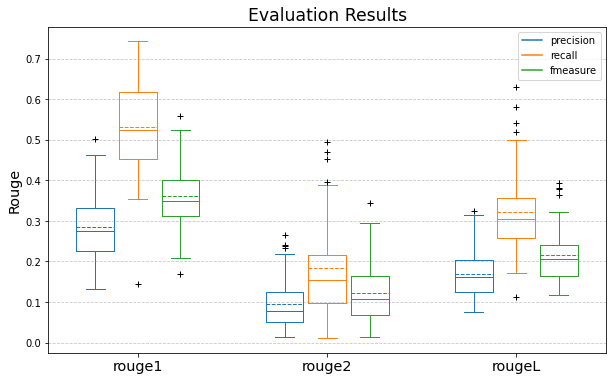

In [50]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')